In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import  xgboost as xgb

import pickle
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns',None)

# Importing Data and taking a look at it

In [2]:
df_1 = pd.read_csv("train.csv")
df_1.shape

(1458644, 11)

In [3]:
df_1.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Data Preprocessing

In [4]:
df_1['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [5]:
#Conver character variables to numeric
f = lambda x: 0 if x=='N' else 1
df_1['store_and_fwd_flag'] = df_1['store_and_fwd_flag'].apply(lambda x: f(x))

In [6]:
#checking result
df_1["store_and_fwd_flag"].value_counts()

0    1450599
1       8045
Name: store_and_fwd_flag, dtype: int64

# Engineer Features

In [7]:
df_1["dropoff_datetime"] = pd.to_datetime(df_1["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
df_1["pickup_datetime"] = pd.to_datetime(df_1["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')

In [8]:
#Now construct other variables, like month, date, etc.
df_1["pickup_month"] = df_1["pickup_datetime"].dt.month
df_1["pickup_day"] = df_1["pickup_datetime"].dt.day
df_1["pickup_weekday"] = df_1["pickup_datetime"].dt.weekday #df_1["pickup_weekday"] = df_1["pickup_datetime"].dt.weekday_name
df_1["pickup_hour"] = df_1["pickup_datetime"].dt.hour
df_1["pickup_minute"] = df_1["pickup_datetime"].dt.minute

In [9]:
#Get latitude and longitude differences 
df_1["latitude_difference"] = df_1["dropoff_latitude"] - df_1["pickup_latitude"]
df_1["longitude_difference"] = df_1["dropoff_longitude"] - df_1["pickup_longitude"]


In [10]:
#Convert duration to minutes for easier interpretation
df_1["trip_duration"] = df_1["trip_duration"].apply(lambda x: round(x/60))   

In [11]:
#Convert trip distance from longitude and latitude differences to Manhattan distance.
df_1["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_1["latitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(df_1["latitude_difference"]) * np.pi / 180) / 2)))))) + \
                                     abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_1["longitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(df_1["longitude_difference"]) * np.pi / 180) / 2)))))))

In [12]:
df_1.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525,1.372146
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,11,6,12,6,0,43,-0.007412,-0.019066,1.829440
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,35,1,19,1,11,35,-0.053852,-0.026306,5.538397
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,7,4,6,2,19,32,-0.013252,-0.002228,1.069567
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,7,3,26,5,13,30,-0.010689,0.000130,0.747485


# Data Visualization

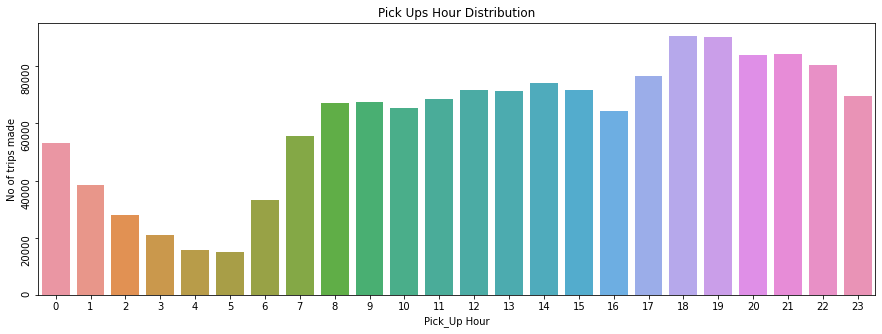

In [13]:
plt.figure(figsize=(15, 5))
sns.countplot(x = 'pickup_hour',data = df_1)
plt.title('Pick Ups Hour Distribution')
plt.xlabel('Pick_Up Hour')
plt.ylabel('No of trips made')
plt.xticks(rotation = 0)
plt.yticks(rotation =90)
plt.show()

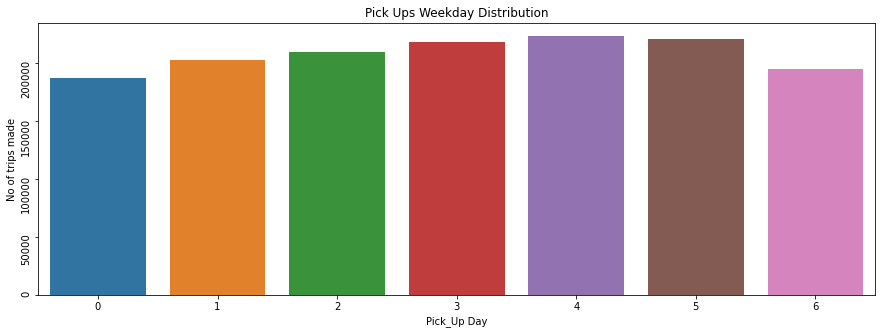

In [14]:
plt.figure(figsize=(15, 5))
sns.countplot(x = 'pickup_weekday',data = df_1)
plt.title('Pick Ups Weekday Distribution')
plt.xlabel('Pick_Up Day')
plt.ylabel('No of trips made')
plt.xticks(rotation = 0)
plt.yticks(rotation =90)
plt.show()

In [15]:
#trip duration distribution

In [16]:
#Trip Duration Histogram By Minutes, Latitudes, and Longtitudes

# Modelling

In [17]:
X = df_1.drop(["trip_duration","id","vendor_id","pickup_datetime","dropoff_datetime"],axis = 1)
y = df_1["trip_duration"]

In [18]:

#Split the data into training, test, and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [19]:
#Define evaluation metric
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [20]:

#XGBoost parameters 
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.05,
    'max_depth':          14,
    'subsample':          0.9,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'feval':              'rmsle'
}

In [21]:
nrounds = 1000

In [22]:

#Define train and validation sets
dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
dval = xgb.DMatrix(X_val, np.log(y_val+1))

#this is for tracking the error
watchlist = [(dval, 'eval'), (dtrain, 'train')]


In [23]:

#Train model
gbm = xgb.train(params,
                dtrain,
                num_boost_round = nrounds,
                evals = watchlist,
                verbose_eval = True
                )

[10:59:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "feval", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-rmse:2.00600	train-rmse:2.00534
[1]	eval-rmse:1.90977	train-rmse:1.90919
[2]	eval-rmse:1.81870	train-rmse:1.81809
[3]	eval-rmse:1.73243	train-rmse:1.73183
[4]	eval-rmse:1.65036	train-rmse:1.64983
[5]	eval-rmse:1.57251	train-rmse:1.57196
[6]	eval-rmse:1.49885	train-rmse:1.49826
[7]	eval-rmse:1.42934	train-rmse:1.42875
[8]	eval-rmse:1.36317	train-rmse:1.36246
[9]	eval-rmse:1.30042	train-rm

[180]	eval-rmse:0.33259	train-rmse:0.22722
[181]	eval-rmse:0.33258	train-rmse:0.22711
[182]	eval-rmse:0.33254	train-rmse:0.22686
[183]	eval-rmse:0.33252	train-rmse:0.22651
[184]	eval-rmse:0.33251	train-rmse:0.22618
[185]	eval-rmse:0.33249	train-rmse:0.22576
[186]	eval-rmse:0.33243	train-rmse:0.22524
[187]	eval-rmse:0.33244	train-rmse:0.22503
[188]	eval-rmse:0.33244	train-rmse:0.22491
[189]	eval-rmse:0.33238	train-rmse:0.22460
[190]	eval-rmse:0.33237	train-rmse:0.22428
[191]	eval-rmse:0.33235	train-rmse:0.22421
[192]	eval-rmse:0.33233	train-rmse:0.22384
[193]	eval-rmse:0.33227	train-rmse:0.22363
[194]	eval-rmse:0.33226	train-rmse:0.22324
[195]	eval-rmse:0.33223	train-rmse:0.22317
[196]	eval-rmse:0.33217	train-rmse:0.22286
[197]	eval-rmse:0.33203	train-rmse:0.22229
[198]	eval-rmse:0.33200	train-rmse:0.22209
[199]	eval-rmse:0.33200	train-rmse:0.22200
[200]	eval-rmse:0.33188	train-rmse:0.22136
[201]	eval-rmse:0.33185	train-rmse:0.22102
[202]	eval-rmse:0.33171	train-rmse:0.22057
[203]	eval-

[371]	eval-rmse:0.32917	train-rmse:0.19053
[372]	eval-rmse:0.32916	train-rmse:0.19043
[373]	eval-rmse:0.32915	train-rmse:0.19017
[374]	eval-rmse:0.32916	train-rmse:0.19007
[375]	eval-rmse:0.32916	train-rmse:0.18995
[376]	eval-rmse:0.32915	train-rmse:0.18989
[377]	eval-rmse:0.32915	train-rmse:0.18987
[378]	eval-rmse:0.32913	train-rmse:0.18960
[379]	eval-rmse:0.32912	train-rmse:0.18946
[380]	eval-rmse:0.32911	train-rmse:0.18917
[381]	eval-rmse:0.32910	train-rmse:0.18901
[382]	eval-rmse:0.32909	train-rmse:0.18872
[383]	eval-rmse:0.32908	train-rmse:0.18847
[384]	eval-rmse:0.32908	train-rmse:0.18837
[385]	eval-rmse:0.32908	train-rmse:0.18833
[386]	eval-rmse:0.32908	train-rmse:0.18827
[387]	eval-rmse:0.32904	train-rmse:0.18806
[388]	eval-rmse:0.32903	train-rmse:0.18802
[389]	eval-rmse:0.32903	train-rmse:0.18800
[390]	eval-rmse:0.32903	train-rmse:0.18781
[391]	eval-rmse:0.32903	train-rmse:0.18765
[392]	eval-rmse:0.32902	train-rmse:0.18747
[393]	eval-rmse:0.32902	train-rmse:0.18733
[394]	eval-

[562]	eval-rmse:0.32812	train-rmse:0.16792
[563]	eval-rmse:0.32812	train-rmse:0.16790
[564]	eval-rmse:0.32812	train-rmse:0.16781
[565]	eval-rmse:0.32811	train-rmse:0.16769
[566]	eval-rmse:0.32811	train-rmse:0.16762
[567]	eval-rmse:0.32811	train-rmse:0.16752
[568]	eval-rmse:0.32811	train-rmse:0.16740
[569]	eval-rmse:0.32810	train-rmse:0.16721
[570]	eval-rmse:0.32810	train-rmse:0.16716
[571]	eval-rmse:0.32810	train-rmse:0.16707
[572]	eval-rmse:0.32810	train-rmse:0.16698
[573]	eval-rmse:0.32809	train-rmse:0.16683
[574]	eval-rmse:0.32809	train-rmse:0.16680
[575]	eval-rmse:0.32809	train-rmse:0.16673
[576]	eval-rmse:0.32808	train-rmse:0.16657
[577]	eval-rmse:0.32808	train-rmse:0.16653
[578]	eval-rmse:0.32808	train-rmse:0.16646
[579]	eval-rmse:0.32808	train-rmse:0.16640
[580]	eval-rmse:0.32808	train-rmse:0.16636
[581]	eval-rmse:0.32808	train-rmse:0.16631
[582]	eval-rmse:0.32808	train-rmse:0.16613
[583]	eval-rmse:0.32808	train-rmse:0.16598
[584]	eval-rmse:0.32808	train-rmse:0.16588
[585]	eval-

[753]	eval-rmse:0.32770	train-rmse:0.15172
[754]	eval-rmse:0.32770	train-rmse:0.15164
[755]	eval-rmse:0.32770	train-rmse:0.15152
[756]	eval-rmse:0.32770	train-rmse:0.15146
[757]	eval-rmse:0.32770	train-rmse:0.15141
[758]	eval-rmse:0.32770	train-rmse:0.15136
[759]	eval-rmse:0.32770	train-rmse:0.15133
[760]	eval-rmse:0.32769	train-rmse:0.15124
[761]	eval-rmse:0.32769	train-rmse:0.15119
[762]	eval-rmse:0.32769	train-rmse:0.15115
[763]	eval-rmse:0.32768	train-rmse:0.15107
[764]	eval-rmse:0.32768	train-rmse:0.15102
[765]	eval-rmse:0.32768	train-rmse:0.15094
[766]	eval-rmse:0.32768	train-rmse:0.15075
[767]	eval-rmse:0.32767	train-rmse:0.15072
[768]	eval-rmse:0.32767	train-rmse:0.15071
[769]	eval-rmse:0.32767	train-rmse:0.15066
[770]	eval-rmse:0.32767	train-rmse:0.15060
[771]	eval-rmse:0.32767	train-rmse:0.15059
[772]	eval-rmse:0.32767	train-rmse:0.15058
[773]	eval-rmse:0.32767	train-rmse:0.15046
[774]	eval-rmse:0.32767	train-rmse:0.15037
[775]	eval-rmse:0.32766	train-rmse:0.15031
[776]	eval-

[944]	eval-rmse:0.32745	train-rmse:0.13846
[945]	eval-rmse:0.32745	train-rmse:0.13836
[946]	eval-rmse:0.32744	train-rmse:0.13824
[947]	eval-rmse:0.32744	train-rmse:0.13815
[948]	eval-rmse:0.32744	train-rmse:0.13800
[949]	eval-rmse:0.32744	train-rmse:0.13795
[950]	eval-rmse:0.32744	train-rmse:0.13792
[951]	eval-rmse:0.32744	train-rmse:0.13788
[952]	eval-rmse:0.32743	train-rmse:0.13783
[953]	eval-rmse:0.32743	train-rmse:0.13780
[954]	eval-rmse:0.32743	train-rmse:0.13778
[955]	eval-rmse:0.32743	train-rmse:0.13771
[956]	eval-rmse:0.32743	train-rmse:0.13766
[957]	eval-rmse:0.32743	train-rmse:0.13758
[958]	eval-rmse:0.32743	train-rmse:0.13750
[959]	eval-rmse:0.32743	train-rmse:0.13744
[960]	eval-rmse:0.32742	train-rmse:0.13726
[961]	eval-rmse:0.32742	train-rmse:0.13712
[962]	eval-rmse:0.32742	train-rmse:0.13708
[963]	eval-rmse:0.32742	train-rmse:0.13702
[964]	eval-rmse:0.32741	train-rmse:0.13692
[965]	eval-rmse:0.32742	train-rmse:0.13688
[966]	eval-rmse:0.32742	train-rmse:0.13687
[967]	eval-

In [24]:
#Test predictions
pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1

In [25]:
#Use mean absolute error to get a basic estimate of the error
mae = (abs(pred - y_test)).mean()
mae

4.823733790692479

In [26]:
#Take a look at feature importance
feature_scores = gbm.get_fscore()
feature_scores

{'passenger_count': 132131.0,
 'pickup_longitude': 492358.0,
 'pickup_latitude': 445020.0,
 'dropoff_longitude': 414887.0,
 'dropoff_latitude': 383285.0,
 'store_and_fwd_flag': 3843.0,
 'pickup_month': 137073.0,
 'pickup_day': 229725.0,
 'pickup_weekday': 119903.0,
 'pickup_hour': 200618.0,
 'pickup_minute': 241221.0,
 'latitude_difference': 316588.0,
 'longitude_difference': 279323.0,
 'trip_distance': 277761.0}

In [27]:
#This is not very telling, so let's scale the features
summ = 0
for key in feature_scores:
    summ = summ + feature_scores[key]

for key in feature_scores:
    feature_scores[key] = feature_scores[key] / summ

feature_scores

{'passenger_count': 0.03596638408421291,
 'pickup_longitude': 0.134021061938038,
 'pickup_latitude': 0.1211355415849152,
 'dropoff_longitude': 0.11293326466572448,
 'dropoff_latitude': 0.10433112232343315,
 'store_and_fwd_flag': 0.0010460740782680083,
 'pickup_month': 0.03731160867302386,
 'pickup_day': 0.06253171158733235,
 'pickup_weekday': 0.03263789232541478,
 'pickup_hour': 0.05460871439863942,
 'pickup_minute': 0.06566095114074609,
 'latitude_difference': 0.0861760344238127,
 'longitude_difference': 0.07603240951445613,
 'trip_distance': 0.07560722926198289}

# Save the Model

In [28]:
filename = "xgb_model.sav"
pickle.dump(gbm, open(filename, 'wb'))